In [ ]:
# Author: Will Connell, A. Wenteler

In [1]:
!pip install scanpy
!pip install scperturb
!pip install scikit-misc


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for scperturb from https://files.pythonhosted.org/packages/0b/96/1f1cdce4b007c24cb7171cf368ced8f1e6723f7132bf0e3afb43cee5858d/scperturb-0.1.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
# datastes here: http://projects.sanderlab.org/scperturb/datavzrd/scPerturb_vzrd_v1/dataset_info/index_1.html

!wget https://zenodo.org/record/7041849/files/NormanWeissman2019_filtered.h5ad

zsh:1: command not found: wget


In [5]:
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix

from scperturb import *

import scanpy as sc
import numpy as np
import pandas as pd
import mpl_sizes

formatter = mpl_sizes.get_format("NeurIPS") # options: ICLR, ICML, NeurIPS, InfThesis

In [6]:
'''
See here: https://github.com/sanderlab/scPerturb/blob/f64821e5e621b3f6147b47f318ae1775d4eff324/revision/snakemake/Snakefile#L177-L215
'''

def equal_subsampling(adata, obs_key, N_min=None):
    '''
    Subsample to same class sizes. Classes given by obs_key pointing to categorical in adata.obs.
    If N_min is given, downsamples to at least this number instead of the number of cells in the smallest class
    and throws out classes with less than N_min cells.
    '''
    counts = adata.obs[obs_key].value_counts()
    groups = counts.index[counts >= N_min]  # ignore groups with less than N_min cells to begin with

    if len(groups) == 0:
        raise ValueError(f"No groups have at least {N_min} cells.")

    # We select downsampling target counts by min-max, i.e.
    # the largest N such that every group has at least N cells before downsampling.
    N = np.min(counts[groups])
    N = max(N, N_min) if N_min else N

    # subsample indices per group
    indices = [
        np.random.choice(
            adata.obs_names[adata.obs[obs_key] == group], size=N, replace=False
        )
        for group in groups
    ]
    selection = np.hstack(np.array(indices))
    return adata[selection].copy()

In [7]:
# Load your anndata object
adata = sc.read_h5ad("../data/norman_2019_raw.h5ad")

In [8]:
adata

AnnData object with n_obs × n_vars = 111445 × 33694
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', '

In [9]:
# rename 'guide_ids' to 'perturbation'
adata.obs['perturbation'] = adata.obs['guide_ids']
total_unique_perts = adata.obs['perturbation'].nunique()
total_unique_perts

237

In [10]:
# filter all the 'perturbation's that contain '_' from the a data object
if 'norman_1':
    adata = adata[~adata.obs['perturbation'].str.contains('_')]
    total_single_gene_perts = adata.obs['perturbation'].nunique()
    print("Number of single gene perturbations: ", total_single_gene_perts - 1)
else:
    print("Working with two-gene perturbations")

Number of single gene perturbations:  236


In [11]:
# Basic QC and preprocessing
print('Shape before filtering: ', adata.shape)
sc.pp.filter_cells(adata, min_counts=1000)
print('Number of perturbations: ', adata.obs['perturbation'].nunique())

# Apply equal subsampling
# adata = equal_subsampling(adata, 'perturbation', N_min=300)
print('Number of perturbations after subsampling: ', adata.obs['perturbation'].nunique())

adata.layers['counts'] = adata.X.copy()
print('Normalizing counts...')
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes(adata, min_cells=50)
print('Applying log1p...')
sc.pp.log1p(adata)
print('Shape after filtering: ', adata.shape)

# Select HVGs
print('Selecting highly variable genes...')
sc.pp.highly_variable_genes(adata, n_top_genes=2000,
                            subset=False, flavor='seurat_v3', layer='counts')
print('Number of perturbations after selecting HVGs: ', adata.obs['perturbation'].nunique())

print('Running PCA...')
sc.pp.pca(adata, use_highly_variable=True, n_comps=50)

# Save the filtered and processed anndata object
# adata.write_h5ad('filtered_anndata.h5ad')

# Display the final number of cells per perturbation
cell_counts = adata.obs['perturbation'].value_counts()
# change the ',' in perturbation to a '+'
adata.obs['perturbation'] = adata.obs['perturbation'].str.replace(',', '+')
adata = adata[:, adata.var.highly_variable]
print(cell_counts)

Shape before filtering:  (111445, 33694)


/Users/aaronw/Desktop/PhD/Research/QMUL/Research/scBench/venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:161: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Number of perturbations:  237
Number of perturbations after subsampling:  237
Normalizing counts...
Applying log1p...
Shape after filtering:  (111445, 17414)
Selecting highly variable genes...
Number of perturbations after selecting HVGs:  237
Running PCA...


/Users/aaronw/Desktop/PhD/Research/QMUL/Research/scBench/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


perturbation
                 11855
KLF1              1960
BAK1              1457
CEBPE             1233
CEBPE,RUNX1T1     1219
                 ...  
CBL,UBASH3A         64
CEBPA,CEBPB         64
CEBPB,JUN           59
C3orf72,FOXL2       59
CEBPA,JUN           54
Name: count, Length: 237, dtype: int64


In [ ]:
df = etest(adata, runs=10000, n_jobs=-1)

print(df.shape)
df['significant_adj'].sum() / len(df)
# save the df results
# remove ctrl from the df
print(df.shape)
df = df[df['perturbation'] != 'ctrl']
print(df.shape)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/aaronw/Desktop/PhD/Research/QMUL/Research/scBench/venv/lib/python3.10/site-packages/scperturb/etest.py:96: RuntimeWarning: invalid value encountered in scalar divide
  delta = np.sum(sc_pwd[idx, :][:, ~idx]) / (N * M)
/Users/aaronw/Desktop/PhD/Research/QMUL/Research/scBench/venv/lib/python3.10/site-packages/scperturb/etest.py:96: RuntimeWarning: invalid value encountered in scalar divide
  delta = np.sum(sc_pwd[idx, :][:, ~idx]) / (N * M)
/Users/aaronw/Desktop/PhD/Research/QMUL/Research/scBench/venv/lib/python3.10/site-packages/scperturb/etest.py:96: RuntimeWarning: invalid value encountered in scalar divide
  delta = np.sum(sc_pwd[idx, :][:, ~idx]) / (N * M)
/Users/aaronw/Desktop/PhD/Research/QMUL/Research/scBench/venv/lib/python3.10/site-packages/scperturb/etest.py:96: RuntimeWarning: invalid value encountered in scalar divide
  delta = np.sum(sc_pwd[idx, :][:, ~idx]) / (N * M)
/Users/aaronw/Desktop/PhD/Research/QMUL/Research/scBench/ve

In [ ]:
df.to_csv('etest_results_all_perts.csv')

In [ ]:
df.head()

(153, 5)


,edist,pvalue,significant,pvalue_adj,significant_adj
AHR,21.986925,0.0001,True,0.015184,True
AHR_KLF1,35.566693,0.0001,True,0.015184,True
ARRDC3,6.685922,0.0001,True,0.015184,True
ATL1,57.990839,0.0001,True,0.015184,True
BAK1,0.725031,0.0282,True,0.082237,False


In [12]:
# open etest results
df = pd.read_csv('etest_results_single_perts.csv')
df

,Unnamed: 0,edist,pvalue,significant,pvalue_adj,significant_adj
0,AHR,21.757839,0.0001,True,0.008464,True
1,ARRDC3,6.931206,0.0001,True,0.008464,True
2,ATL1,60.535701,0.0001,True,0.008464,True
3,BAK1,0.994366,0.0104,True,0.030877,True
4,BCL2L11,0.082736,0.2923,False,0.499161,False
...,...,...,...,...,...,...
80,ZBTB1,27.508356,0.0001,True,0.008464,True
81,ZBTB25,13.570649,0.0001,True,0.008464,True
82,ZC3HAV1,3.710965,0.0001,True,0.008464,True
83,ZNF318,2.619759,0.0001,True,0.008464,True


<Axes: >

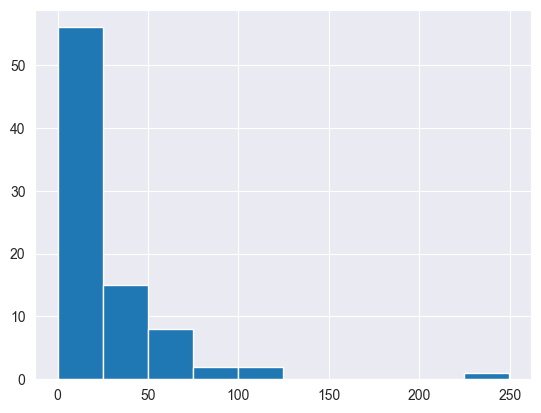

In [7]:
# plot histogram of edist values
df['edist'].hist()

In [8]:
df = df.rename(columns={'Unnamed: 0': 'perturbation'})
# remove perturbation 'control' from the df
df = df[df['perturbation'] != 'control']

# calculate the mean e-distance across the entire dataset (column 'edist') and the associated p-value (column 'pvalue_adj').
df['edist'].mean()

26.777577459631395

In [9]:
from scipy.stats import combine_pvalues

# Assuming df is your DataFrame and 'pvalue_adj' is the column with p-values
p_values = df['pvalue_adj'].values

# Use Fisher's method to combine p-values
_, combined_p_value = combine_pvalues(p_values, method='fisher')

print(f"Combined p-value: {combined_p_value}")

Combined p-value: 1.2252751342846089e-80


## Calculate sigma values for perturbation 

In [46]:
boolean_idx = adata.obs['guide_ids'] == 'CEBPA'
adata.shape

(111445, 17414)

In [31]:
# extract the expression for 'CEBPA' from adata 
cebpa_expr = adata[boolean_idx,:].X.toarray()

In [54]:
# calculate the sum of the euclidean distances between all the cells
all_edist = []
for i in range(cebpa_expr.shape[0]):
    for j in range(cebpa_expr.shape[0]):
        if i != j:
            all_edist.append(np.linalg.norm(cebpa_expr[i] - cebpa_expr[j]))

sigma_y_cebpa = sum(all_edist) / (cebpa_expr.shape[0] ** 2)
sigma_y_cebpa

62.9345994717863

In [48]:
boolean_idx_ikzf3 = adata.obs['guide_ids'] == 'IKZF3'
# extract the expression for 'IKZF3' from adata
ikzf3_expr = adata[boolean_idx_ikzf3,:].X.toarray()

In [50]:
ikzf3_expr.shape

(681, 17414)

In [53]:
# calculate the sum of the euclidean distances between all the cells
all_edist_ikzf3 = []
for i in range(ikzf3_expr.shape[0]):
    for j in range(ikzf3_expr.shape[0]):
        if i != j:
            all_edist_ikzf3.append(np.linalg.norm(ikzf3_expr[i] - ikzf3_expr[j]))

sigma_y_ikzf3 = sum(all_edist_ikzf3) / (ikzf3_expr.shape[0]) ** 2
sigma_y_ikzf3

54.687621580808994

In [35]:
# calculate the mean of cebpa and ikzf3 across all cells 
cebpa_mean = cebpa_expr.mean(axis=0)
ikzf3_mean = ikzf3_expr.mean(axis=0)
# sort the mean values descending
cebpa_mean = np.sort(cebpa_mean)[::-1]
ikzf3_mean = np.sort(ikzf3_mean)[::-1]

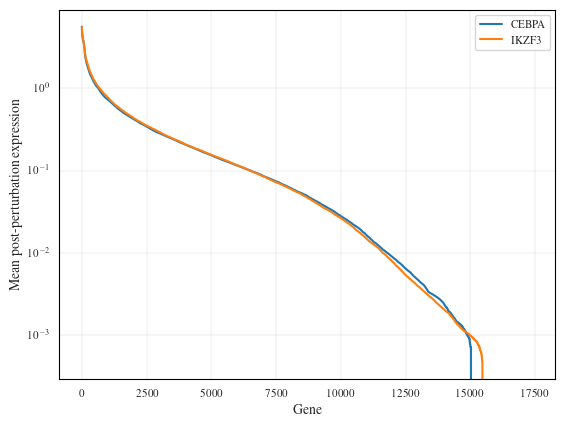

In [45]:
# plot a line plot of the mean expression of cebpa and ikzf3
import matplotlib.pyplot as plt

x = np.arange(cebpa_mean.shape[0])
plt.plot(x, cebpa_mean, label='CEBPA')
plt.plot(x, ikzf3_mean, label='IKZF3')
plt.yscale('log')
plt.xlabel('Gene')
plt.ylabel('Mean post-perturbation expression')
plt.gca().set_facecolor('white')
plt.grid(color='grey', linestyle='-', linewidth=0.1)
# set all spines to black 
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.legend(facecolor='white')
plt.savefig('../plots/paper_figs/CEBPA_IKZF3.pdf', dpi=300)